In [ ]:
# -----------------------------------------------------------------------------------
# 파일명       : Data_Preprocessing.ipynb
# 설명         : 스켈레톤 시계열 데이터를 모델 학습을 위해 전처리
#                데이터 보간, 결측치 처리 등의 기능을 포함
# 작성자       : 이민하
# 작성일       : 2025-04-20
# 
# 사용 모듈    :
# - pandas       # 데이터프레임 기반 데이터 처리
# - numpy        # 수치 계산 및 배열 연산
# - os           # 파일 및 경로 관리
# - cv2          # OpenCV를 활용한 이미지 및 비디오 처리
# - matplotlib   # 시각화 및 그래프 출력
# -----------------------------------------------------------------------------------
# >> 주요 기능
# - 랜드마크 결측치 보간 (ffill(), bfill(), interpolate() 사용)
# - 라벨링 데이터의 결측치 처리
#
# >> 업데이트 내역
# [2025-04-20] 랜드마크 결측값 보간 및 디버깅 기능 개발
# [2025-04-28] 라벨 데이터 결측값 처리 기능 개발
# [2025-05-10] 처리 대상 프레임률을 30fps → 10fps로 리팩토링
# -----------------------------------------------------------------------------------


In [ ]:
# 데이터프레임 기반 데이터 처리
import pandas as pd

# 수치 계산 및 배열 연산
import numpy as np

# 파일 및 경로 관리
import os

# OpenCV를 활용한 이미지 및 비디오 처리
import cv2

# 시각화 및 그래프 출력
import matplotlib.pyplot as plt

In [ ]:
# 저장 경로 설정
DATA_PATH = "./10fps_Dataset"

# 경로 내 CSV파일 경로 저장
csv_files = sorted([os.path.join(DATA_PATH, f) for f in os.listdir(DATA_PATH) if f.endswith('.csv')])

csv_files

['./10fps_Dataset\\pose_landmark_0000.csv',
 './10fps_Dataset\\pose_landmark_0001.csv',
 './10fps_Dataset\\pose_landmark_0002.csv',
 './10fps_Dataset\\pose_landmark_0003.csv',
 './10fps_Dataset\\pose_landmark_0004.csv',
 './10fps_Dataset\\pose_landmark_0005.csv',
 './10fps_Dataset\\pose_landmark_0006.csv',
 './10fps_Dataset\\pose_landmark_0007.csv',
 './10fps_Dataset\\pose_landmark_0008.csv',
 './10fps_Dataset\\pose_landmark_0009.csv',
 './10fps_Dataset\\pose_landmark_0010.csv',
 './10fps_Dataset\\pose_landmark_0011.csv',
 './10fps_Dataset\\pose_landmark_0012.csv',
 './10fps_Dataset\\pose_landmark_0013.csv',
 './10fps_Dataset\\pose_landmark_0014.csv',
 './10fps_Dataset\\pose_landmark_0015.csv',
 './10fps_Dataset\\pose_landmark_0016.csv',
 './10fps_Dataset\\pose_landmark_0017.csv',
 './10fps_Dataset\\pose_landmark_0018.csv',
 './10fps_Dataset\\pose_landmark_0019.csv',
 './10fps_Dataset\\pose_landmark_0020.csv',
 './10fps_Dataset\\pose_landmark_0021.csv',
 './10fps_Dataset\\pose_landmark

In [ ]:
# 데이터 저장 경로 설정
SAVE_PATH = "./new_10fps_Dataset3/"

for i, csv in enumerate(csv_files):
    # CSV 불러오기
    df = pd.read_csv(csv)

    # 프레임과 랜드마크 ID 목록 생성
    # 1 ~ 300 프레임까지 (10초짜리 영상을 초당 10프레임만큼 추출 -> step = 3)
    all_frames = np.arange(1, 301, 3)
    all_landmarks = df['landmark_id'].unique()

    df_frames = df["frame"].unique()

    frame_list = []
    landmark_list = []

    # 초당 10프레임 중 비어있는 항목까지 추가
    for frame in all_frames:
        if frame not in df_frames:
            for landmark in all_landmarks:
                frame_list.append(frame)
                landmark_list.append(landmark)
    
    # 비어있는 항목에 결측치가 있는 초당 10프레임을 측정한 데이터프레임 생성
    add_row = pd.DataFrame({"frame" : frame_list, "landmark_id" : landmark_list})

    df = pd.concat([df, add_row], ignore_index = True)

    df = df.groupby("landmark_id").apply(lambda x : x.sort_values(by = ["frame", "landmark_id"]).interpolate().ffill().bfill()).reset_index(drop=True)
    df = df.sort_values(by = ["frame", "landmark_id"])
    
    # 새롭게 바꾼 데이터프레임을 CSV 파일로 저장
    df.to_csv(SAVE_PATH + f"pose_landmark_{i:04d}.csv", index = False)


In [ ]:
# 관절 위치 디버깅 함수 
def draw_landmarks_sequential(video_path, csv_path, resize=(960, 540)):
    # 관절 위치 좌표 데이터 불러오기
    df = pd.read_csv(csv_path)
    # 영상 데이터 불러오기
    cap = cv2.VideoCapture(video_path)

    # 영상 크기 설정
    original_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    frame_id = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        landmarks = df[df['frame'] == frame_id]

        # 영상에 랜드마크별 좌표 그리기
        for _, row in landmarks.iterrows():
            
            # 영상 크기에 따른 좌표값 일반화
            x = int(row['x'] * original_width)
            y = int(row['y'] * original_height)

            # 좌표값에 원 그리기
            cv2.circle(frame, (x, y), 15, (0, 255, 0), -1)

        if resize:
            frame = cv2.resize(frame, resize)

        cv2.imshow("Pose Replay", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):  # 1ms로 재생
            break

        frame_id += 0.5 # 영상 : 60fps, 데이터 : 30fps 기준

    cap.release()
    cv2.destroyAllWindows()

# 영상 데이터 경로 설정
VIDEO_PATH = r"F:/Fall_Detection_Data/Source_Data/Video/"

# 관절 좌표 데이터 경로 설정
CSV_PATH = "./New_Dataset/"


# CSV 파일 경로 저장
csv_files = []

for file in os.listdir(CSV_PATH):
    csv_files.append(os.path.join(CSV_PATH, file))

# 영상 데이터 경로 저장
path_list = []

for dirpath, _, filenames in os.walk(VIDEO_PATH):
    for filename in filenames:
        if filename.endswith((".mp4", ".MP4")):
            path_list.append(os.path.join(dirpath, filename))

# 영상별로 관절 위치 디버깅
for i, path in enumerate(path_list):
    draw_landmarks_sequential(path, csv_files[i])

KeyboardInterrupt: 

: 

In [ ]:
# 라벨링 데이터 불러오기
label_df = pd.read_csv("Label.csv")

label_df

source_index  label
0                0      0
1                1      0
2                2      0
3                3      0
4                4      0
...            ...    ...
4267          4267      1
4268          4268      1
4269          4269      1
4270          4270      1
4271          4271      1

[4272 rows x 2 columns]

In [ ]:
# 병합된 관절 데이터 불러오기
data_df = pd.read_csv("10fps_merged_data.csv")

data_df

frame  landmark_id         x         y         z  source_index
0             1            0  0.432988  0.559980 -0.354303             0
1             1           11  0.465422  0.526178 -0.257993             0
2             1           12  0.408942  0.558263 -0.288992             0
3             1           13  0.474997  0.550322 -0.326235             0
4             1           14  0.391634  0.598874 -0.350726             0
...         ...          ...       ...       ...       ...           ...
14756568    300           24  0.474064  0.542400 -0.034562          4271
14756569    300           25  0.518767  0.611720  0.045855          4271
14756570    300           26  0.491121  0.633001 -0.042814          4271
14756571    300           29  0.480062  0.622083  0.255259          4271
14756572    300           30  0.479840  0.649693  0.159643          4271

[14756573 rows x 6 columns]

In [ ]:
label_source_index = label_df["source_index"].unique()
data_source_index = data_df["source_index"].unique()

# 결측치 제거 후 사라진 영상의 데이터 제거
for i in label_source_index:
    if i not in data_source_index:
        idx = label_df[label_df["source_index"] == i].index
        label_df.drop(idx, axis = 0, inplace = True)

In [10]:
len(data_source_index)

3781

In [11]:
len(label_df)

3781

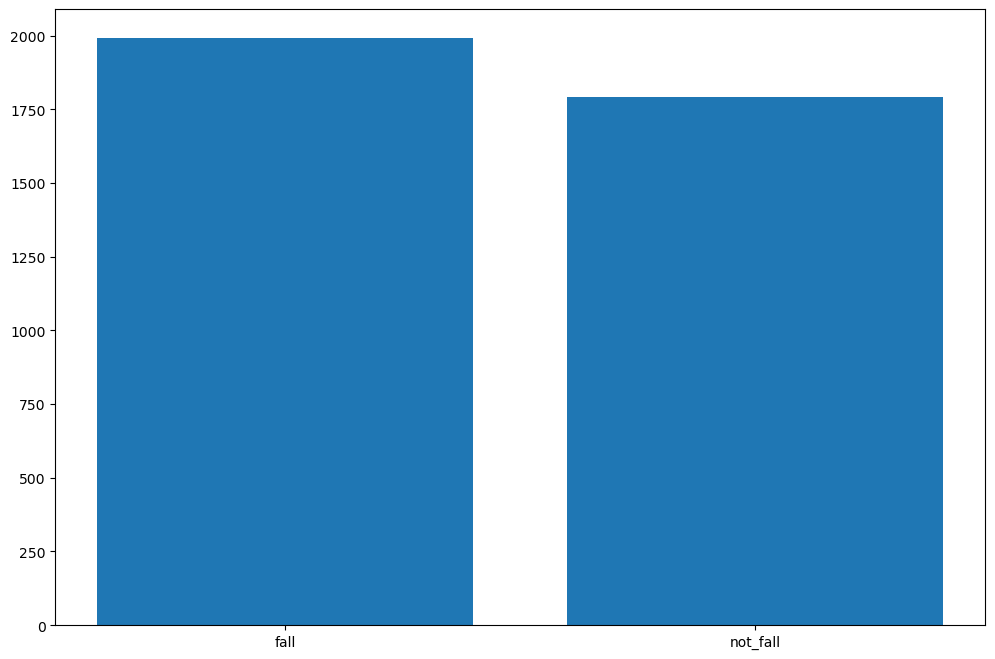

In [ ]:
# 데이터 불균형 확인
fall = len(label_df[label_df["label"] == 1])
not_fall = len(label_df[label_df["label"] == 0])

plt.figure(figsize = (12, 8))
plt.bar(["fall", "not_fall"], [fall, not_fall])
plt.show()